In [ ]:
#Caso precise!

from google.colab import drive
drive.mount('/content/drive')

# Projeto de Identificação de Danos em Veículos com Vertex AI

Esse notebook utiliza o AutoML do Vertex AI, uma ferramenta que facilita a criação de modelos de alta performance, ideal para quem possui pouco conhecimento em Machine Learning, pois automatiza grande parte do processo, esta será a base para costruir o modelo.

## Objetivo da Sprint

Para esta sprint, decidimos utilizar um conjunto de imagens fornecido pelo Google, que considera fatores importantes, como a resolução da imagem e a distância da câmera em relação ao objeto, o que impacta diretamente na qualidade do dataset. Esse ponto é discutido no artigo [*Formulating a More Effective Way to Identify Vehicle Damage with Explainable AI*](https://cloud.google.com/blog/products/ai-machine-learning/identifying-vehicle-damage-effectively-with-explainable-ai), que explora o uso de uma ferramenta chamada *Image Qualifier Model*. Esse modelo avalia se uma imagem é adequada para ser usada no treinamento.

## Estrutura do Dataset

Nosso dataset incluirá imagens de cinco partes específicas de veículos:

- **Para-brisa**
- **Lateral**
- **Capô**
- **Motor**
- **Para-choque**

Cada imagem será rotulada com a parte do veículo correspondente, em casos reais poderíamos usar um modelo de multi-classificação já que ele trataria o quão grave é o dano / qual o tipo do dano e outras partes do carro. Embora modelos profissionais geralmente exijam mais de 100 imagens por parte, para este projeto acadêmico trabalharemos com cerca de 100 imagens para cada uma. As imagens apresentam diferentes tipos de danos, como rachaduras em vidro, arranhões, batidas e deformações no metal.

##Geração de Orçamento com Base na Previsão
Neste projeto com base na parte do veículo identificada, será possível gerar um orçamento para o reparo. Caso fosse aplicado verdadeiramente, esse orçamento levará em consideração o tipo de problema, o modelo do veículo e outros fatores, garantindo uma estimativa precisa e personalizada para o cliente.

Esse projeto demonstra como o AutoML do Vertex AI pode ser utilizado para automatizar e otimizar o processo de identificação de danos (até então físicos) em veículos, contribuindo para uma análise eficiente e fundamentada.

##Funcionamento do Modelo

O modelo final fornecerá uma previsão com a parte do veículo identificada e uma porcentagem de confiança para cada dano detectado. A saída seguirá um formato semelhante ao exemplo abaixo:

```json
{
  "predictions": [
    {
      "confidences": [0.951557755],
      "displayNames": ["bumper"],
      "ids": ["1960986684719890432"]
    }
  ],
  "deployedModelId": "4271461936421404672",
  "model": "projects/1030115194620/locations/REGION/models/2143634257791156224",
  "modelDisplayName": "damaged_car_parts_vertex",
  "modelVersionId": "1"
}



#Ativar o Cloud Shell

O Cloud Shell é uma máquina virtual equipada com ferramentas de desenvolvimento, oferecendo um diretório pessoal persistente de 5 GB e executando no Google Cloud. Ele permite acesso à linha de comando para seus recursos no Google Cloud.

Clique em Ativar Cloud Shell no ícone de Cloud Shell no topo do console do Google Cloud. Quando a conexão for estabelecida, você já estará autenticado e o projeto estará configurado para o seu Project_ID, >*PROJECT_ID*. A saída inclui uma linha que exibe o Project_ID para essa sessão.

#Considerações

Você precisa de uma conta no Google Cloud e créditos para esse projeto funcionar, só pelo free trial do google é possível concluir esse notebook

Este notebook funciona da seguinte maneira:

1 - Você pode copiar as células para o terminal Cloud Shell e ir seguindo as orientações

OU

<table align="center">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/L3to/IASprint4/main/Sprint_4_IA_Usando_o_AutoML_Vision.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Abra no<br>Vertex AI Workbench
    </a>
  </td>

Peço para que faça o download das imagens seguintes para teste!
São diversas partes de carros que não estão no dataset e uma imagem que não tem relação com eles para ver como o programa irá reagir, essas imagens precisam ser posteriormente ser indicadas em paths relativos então deixe-as em algum lugar fácil

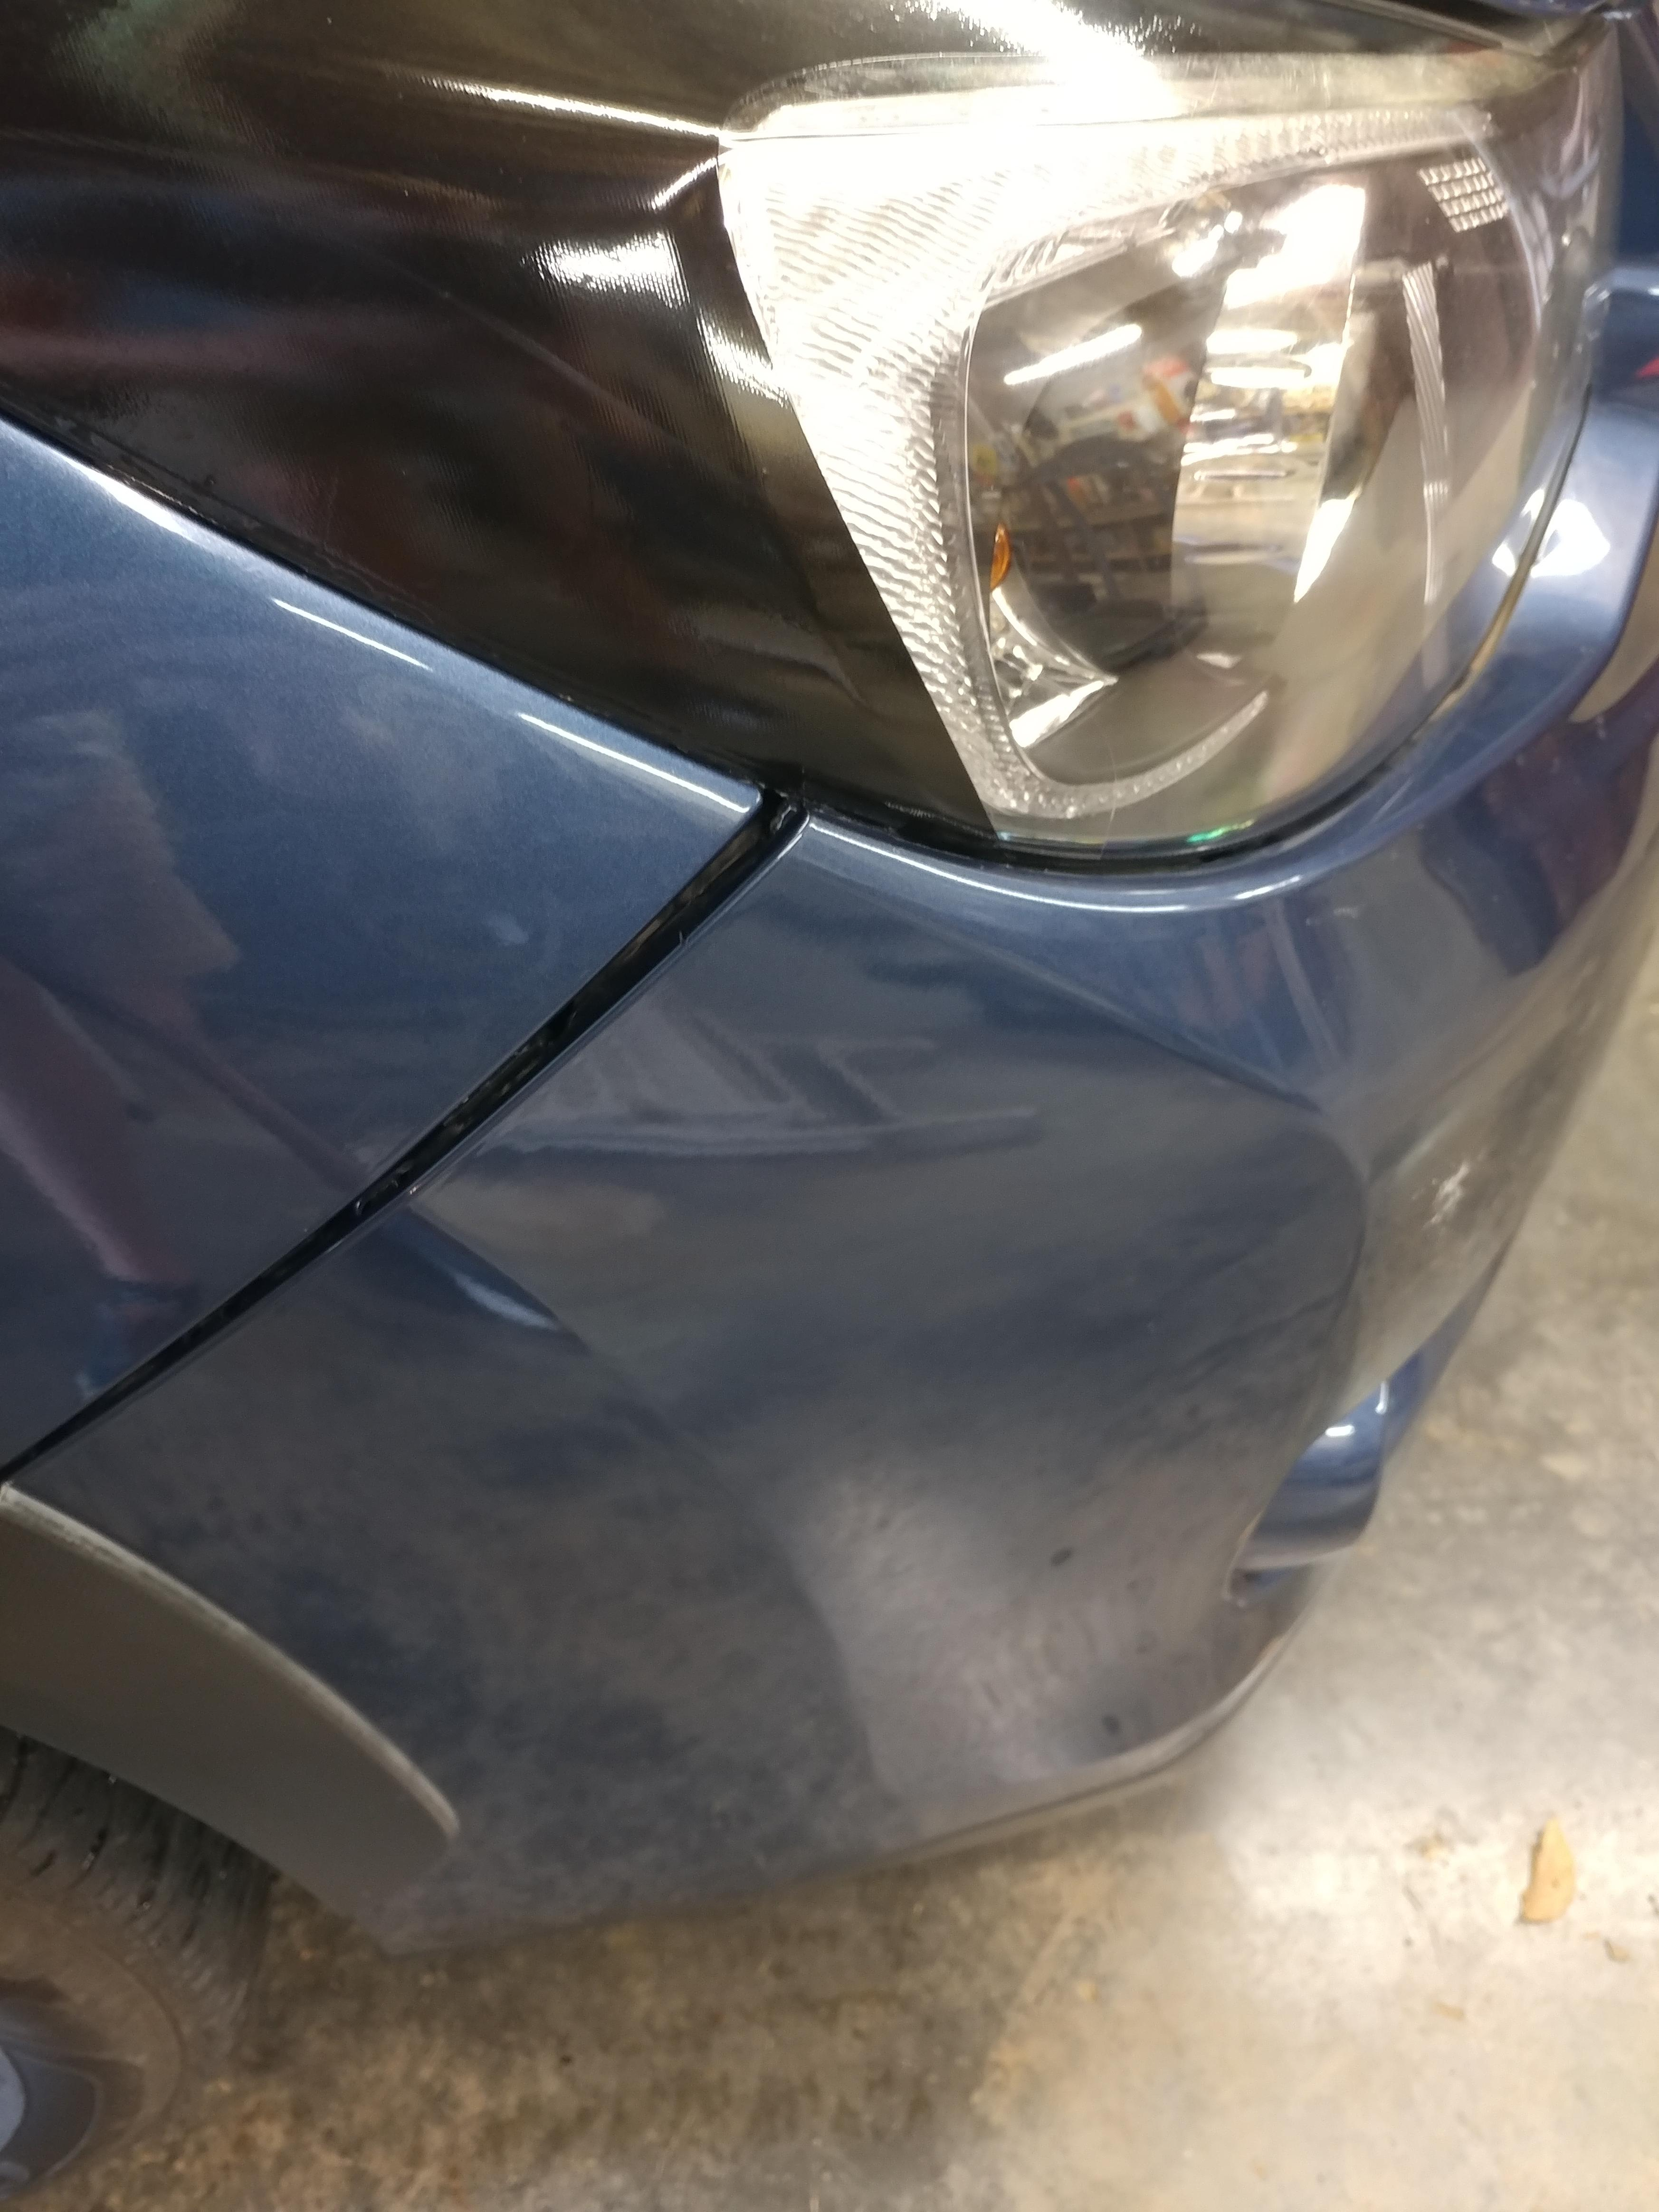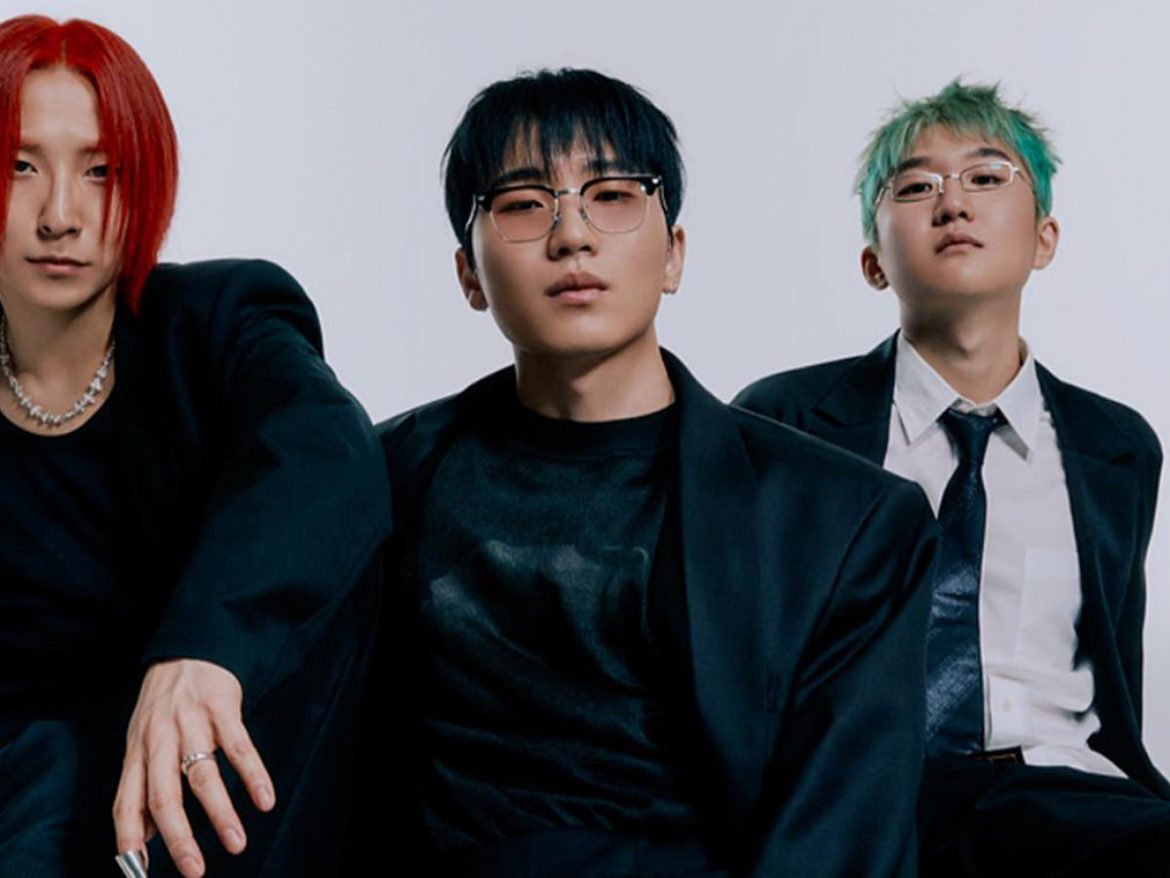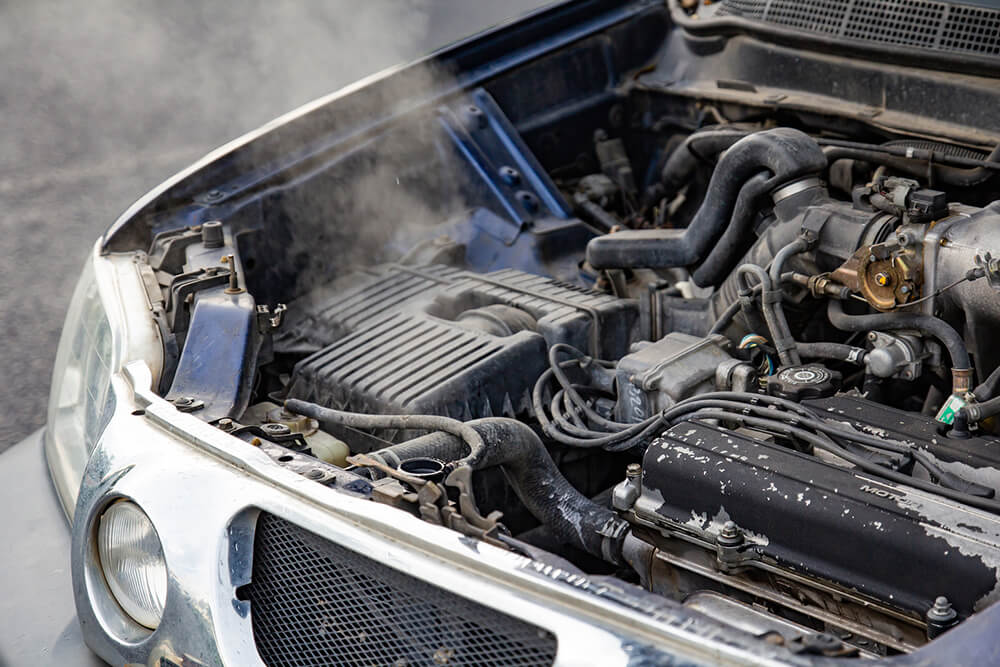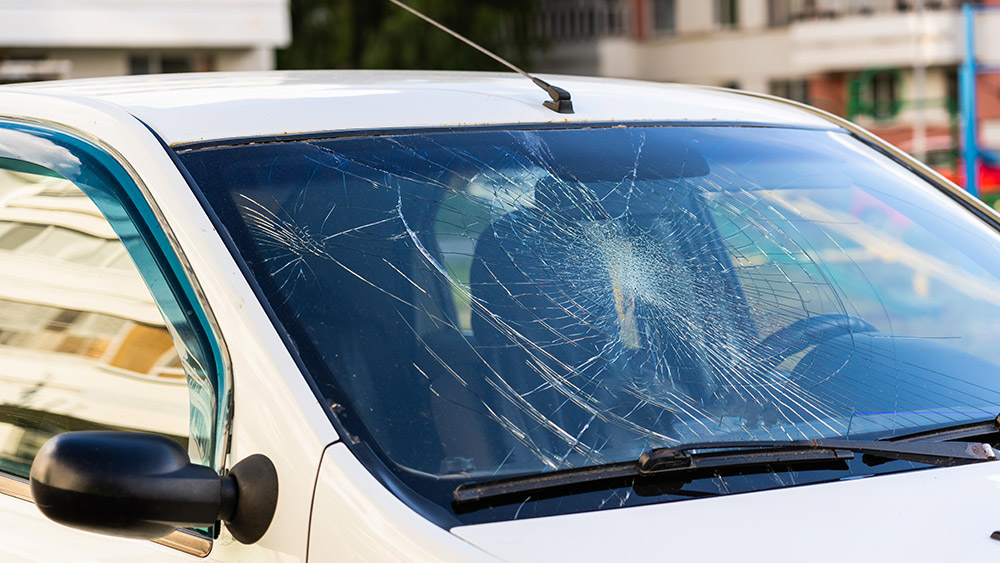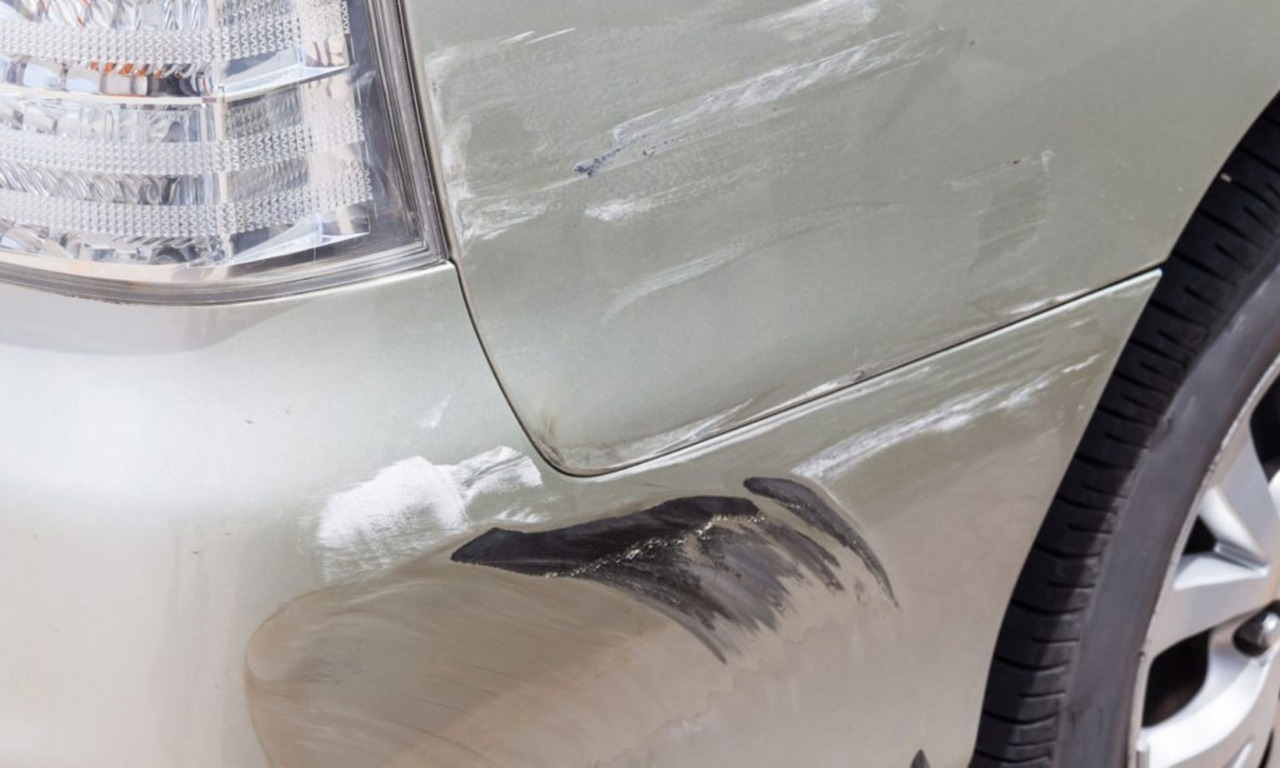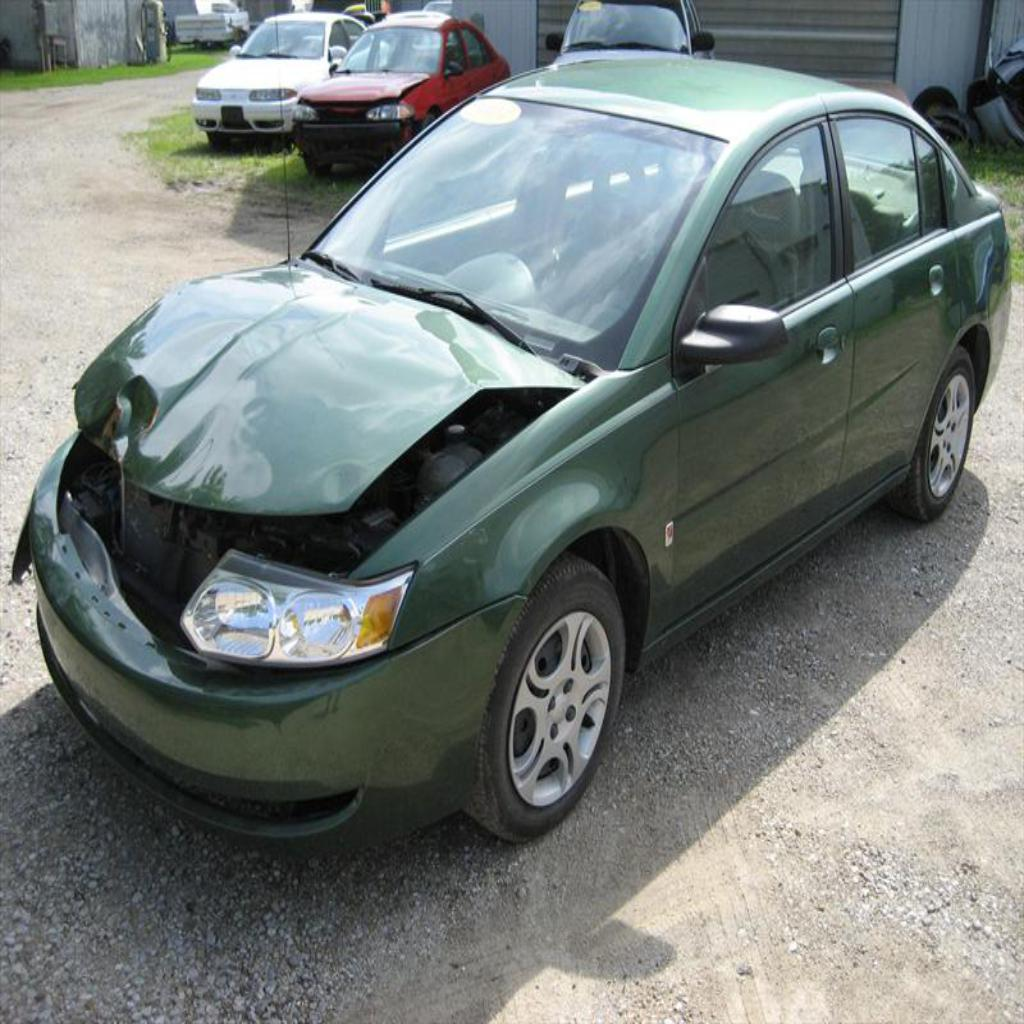

# **GOOGLE CLOUD CLOUD**


Abra uma instância do Cloud Shell no canto superior direito da tela (Símbolo do terminal), logo após defina as seguintes variáveis de ambiente:

In [ ]:
export PROJECT_ID=$DEVSHELL_PROJECT_ID
export BUCKET=$PROJECT_ID

Crie o **Cloud Storage bucket**

In [ ]:
gsutil mb -p $PROJECT_ID \
    -c standard    \
    -l us-central1 \
    gs://${BUCKET}

Upload das [imagens](gs://car_damage_lab_images/) para o Cloud Storage, dê refresh na página do Storage!

In [ ]:
gsutil -m cp -r gs://car_damage_lab_images/* gs://${BUCKET}

Agora, iremos criar uma cópia do data.csv, nele as imagens já estão divididas em treino, teste e validação do modelo para o Vertex cuidar.

In [ ]:
gsutil cp gs://car_damage_lab_metadata/data.csv .

Vou atualizar o path do CSV para o nosso armazenamento

In [ ]:
sed -i -e "s/car_damage_lab_images/${BUCKET}/g" ./data.csv

Upload do CSV para o CLoud Storage bucket

In [ ]:
gsutil cp ./data.csv gs://${BUCKET}

(verifique se o Storage contém o `data.csv`)

# Criar um Dataset Gerenciado

1. No Google Cloud Console, no menu de navegação (ícone do menu de navegação), clique em **Vertex AI > Dashboard**.
   
2. Clique em **Ativar todas as APIs recomendadas** se ainda não estiver ativado.

3. No menu de navegação do Vertex AI à esquerda, clique em **Conjuntos de Dados**.

4. No topo do console, clique em **+ Criar**.

5. Para o **Nome do Conjunto de Dados**, digite `carro_partes`.

6. Selecione **Classificação de Imagem (Single Label)**.

7. Selecione a **Região** como `us-central1`.

8. Clique em **Criar**.


# Conectar seu Conjunto de Dados às Imagens de Treinamento

Nesta seção, você irá escolher a localização das imagens de treinamento que você enviou na etapa anterior.

1. Na seção **Selecionar um método de importação**, clique em **Selecionar arquivos de importação do Cloud Storage**.

2. Na seção **Selecionar arquivos de importação do Cloud Storage**, clique em **Navegar**.

3. Siga as instruções para localizar seu bucket de armazenamento e clique no arquivo `data.csv`. Em seguida, clique em **Selecionar**.

4. Após selecionar corretamente o arquivo, uma marca de seleção verde aparecerá à esquerda do caminho do arquivo. Clique em **Continuar** para prosseguir.

**Observação:** O processo de importação das imagens e a alocação às suas respectivas categorias pode levar de 9 a 12 minutos. Você precisará aguardar a conclusão dessa etapa antes de verificar o progresso.

5. Uma vez que a importação estiver concluída, prepare-se para a próxima seção clicando na aba **Navegar**. (Talvez possa ser necessário atualizar a página para confirmar a conclusão.)

Verifique as labels das imagens e caso necessário faça alterações
texto

#Treinar seu Modelo

Agora você está pronto para começar a treinar seu modelo! O Vertex AI cuida de tudo automaticamente, sem que você precise escrever nenhum código do modelo.

1. No lado direito, clique em **Treinar Novo Modelo**.

2. Na janela **Método de Treinamento**, mantenha as configurações padrão e selecione **AutoML** como o método de treinamento. Clique em **Continuar**.

3. Na janela **Detalhes do Modelo**, insira um nome para seu modelo: `carro_partes_model`. Clique em **Continuar**.

4. Na janela **Opções de Treinamento**, selecione **Maior precisão (novo)** e clique em **Continuar**.

5. Na janela **Computação e Preços**, defina seu orçamento para **8 horas máximas de nó**.

6. Clique em **Iniciar Treinamento**. (Podem demorar horas)


#Configure o endpoint

Vamos implementar um endpoint para conexão do modelo com a API Rest.
1. No lado direito vá para a seção Deploy and Use
2. Escolha seu modelo
3. Vá até a divisão de Implementar e testar
4. Implemente um endpoint, configurações padrões em "**Defina seu endpoint**" e escolha um nome, a região deixe `us-central1`
5. Em **Configurações do modelo** deixe 100 para divisão de tráfego e coloque **1 nó de computação**


#Estamos prontos! Vamos pegar agora as credenciais para a API Rest

Para acessarmos o modelo por fora, precisamos de autorizações do sistema que são essas credenciais. Elas servem para proteger e conectar nosso programa com a Google Cloud, essas informações são importantes porque dão acesso ao nosso projeto ainda mais com as permissões indevidas!

1. No lado direito vá para a seção API e serviços
2. Clique em **Credenciais**
3. Crie uma nova conta de serviço com **qualquer ID**
4. Dê à ela permissão de Editor
5. Depois de criada selecione ela
6. Vá em chaves, adicione uma em **JSON** e baixe e deixe salvo na mesma pasta do arquivo .py que chamaremos a API Rest

# Implementando em CLI

Agora é possível executar consultas usando a interface de linha de comando (CLI).

Verifique se você tem o SDK do Google Cloud instalado. Execute o comando a seguir para fazer a autenticação com sua conta do Google.

```bash
gcloud auth application-default login

{
  "instances": [{
    "content": "YOUR_IMAGE_BYTES"
  }],
  "parameters": {
    "confidenceThreshold": 0.5,
    "maxPredictions": 5
  }
}

ENDPOINT_ID="(seu ID)"
PROJECT_ID="(seu ID)"
INPUT_DATA_FILE="(seu input)"

curl \
-X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
"https://us-central1-aiplatform.googleapis.com/v1/projects/${PROJECT_ID}/locations/us-central1/endpoints/${ENDPOINT_ID}:predict" \
-d "@${INPUT_DATA_FILE}"


# Implementando no Python

Para a credencial é necessário definir o default já que não vem pré-setado\

In [ ]:
import os
import json
import base64
from google.auth import default
from google.auth.transport.requests import Request
import requests

# Configurando o GOOGLE_APPLICATION_CREDENTIALS como variável de ambiente
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = #Path relativo da suas credenciais em .json

SyntaxError: invalid syntax (<ipython-input-1-2366d1c6bb3e>, line 1)

Todo código em Python está aqui e mostrando uma sample de como ele poderia funcionar, usando a base de dados SQL com os preços levando em conta a gravidade (possível upgrade do modelo para multi-classificação) e o modelo do carro, o orçamento já seria feito aqui rapidamente

In [4]:
import json
import base64
from google.auth import default
from google.auth.transport.requests import Request
import requests

# 1. Configurações e IDs (Os IDs podem ser pegos na seção de endpoints que mostra alguns sample codes com o Google SDK, aproveite-os)
ENDPOINT_ID =   # ID do endpoint
PROJECT_ID =           # ID do projeto no Google Cloud
IMAGE_PATH = "seguro-cobre-riscos-na-pintura.jpg"     # Caminho da imagem

# Verificar se a imagem é do tipo .webp
if IMAGE_PATH.lower().endswith('.webp'):
    print("Essa imagem não é compatível.")
    exit(1)

# 2. Carregar e codificar a imagem em base64
try:
    with open(IMAGE_PATH, "rb") as image_file:
        image_content = base64.b64encode(image_file.read()).decode("utf-8")
except FileNotFoundError:
    print(f"Erro: Arquivo '{IMAGE_PATH}' não encontrado.")
    exit(1)

# 3. Criar payload JSON
input_data = {
    "instances": [{
        "content": image_content
    }],
    "parameters": {
        "confidenceThreshold": 0.5,
        "maxPredictions": 5
    }
}

# 4. Obter token de autenticação
credentials, project = default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
credentials.refresh(Request())
auth_token = credentials.token

# 5. Definir a URL do endpoint
url = f"https://us-central1-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/us-central1/endpoints/{ENDPOINT_ID}:predict"

# 6. Configurar cabeçalhos da solicitação
headers = {
    "Authorization": f"Bearer {auth_token}",
    "Content-Type": "application/json"
}

# 7. Enviar a solicitação
response = requests.post(url, headers=headers, json=input_data)

# 8. Verificar a resposta
if response.status_code == 200:
    predictions = response.json().get("predictions", [])

    if not predictions:
        print("Nenhuma previsão retornada. Verifique a imagem e o modelo.")
    else:
        prediction = predictions[0]

        # Tentar obter os valores de displayNames e confidences com segurança
        display_names = prediction.get('displayNames', [])
        confidences = prediction.get('confidences', [])

        if not display_names or not confidences:
            print("O modelo não conseguiu tratar esta imagem.")
        else:
            display_name = display_names[0]
            confidence = confidences[0]

            # Verificar a confiança da predição
            if confidence < 0.6:
                print("O sistema não pode fazer a previsão com precisão.")
            else:
                # Dicionário de preços
                carros = {
                    "Toyota Corolla": {"Parabrisas": 500, "Compartimento do motor": 1500, "Lateral": 1200, "Capô": 1300, "Parachoque": 700},
                    "Honda Civic": {"Parabrisas": 550, "Compartimento do motor": 1550, "Lateral": 1250, "Capô": 1350, "Parachoque": 750},
                    "Ford Focus": {"Parabrisas": 600, "Compartimento do motor": 1600, "Lateral": 1300, "Capô": 1400, "Parachoque": 800},
                    "Chevrolet Cruze": {"Parabrisas": 650, "Compartimento do motor": 1650, "Lateral": 1350, "Capô": 1450, "Parachoque": 850},
                    "Volkswagen Jetta": {"Parabrisas": 700, "Compartimento do motor": 1700, "Lateral": 1400, "Capô": 1500, "Parachoque": 900},
                    "Nissan Sentra": {"Parabrisas": 620, "Compartimento do motor": 1580, "Lateral": 1320, "Capô": 1420, "Parachoque": 820},
                    "Hyundai Elantra": {"Parabrisas": 640, "Compartimento do motor": 1620, "Lateral": 1380, "Capô": 1520, "Parachoque": 840},
                    "Kia Cerato": {"Parabrisas": 630, "Compartimento do motor": 1590, "Lateral": 1360, "Capô": 1460, "Parachoque": 830},
                    "Renault Kwid": {"Parabrisas": 400, "Compartimento do motor": 1200, "Lateral": 1000, "Capô": 900, "Parachoque": 600},
                    "Fiat Argo": {"Parabrisas": 480, "Compartimento do motor": 1300, "Lateral": 1100, "Capô": 950, "Parachoque": 650},
                    "Peugeot 208": {"Parabrisas": 500, "Compartimento do motor": 1350, "Lateral": 1150, "Capô": 1000, "Parachoque": 700},
                    "Citroën C3": {"Parabrisas": 520, "Compartimento do motor": 1400, "Lateral": 1200, "Capô": 1050, "Parachoque": 720},
                    "Toyota Yaris": {"Parabrisas": 550, "Compartimento do motor": 1450, "Lateral": 1250, "Capô": 1100, "Parachoque": 740},
                    "Honda HR-V": {"Parabrisas": 600, "Compartimento do motor": 1500, "Lateral": 1300, "Capô": 1150, "Parachoque": 800},
                    "Ford EcoSport": {"Parabrisas": 570, "Compartimento do motor": 1480, "Lateral": 1280, "Capô": 1130, "Parachoque": 780},
                    "Chevrolet Tracker": {"Parabrisas": 650, "Compartimento do motor": 1550, "Lateral": 1350, "Capô": 1200, "Parachoque": 820},
                    "Volkswagen T-Cross": {"Parabrisas": 680, "Compartimento do motor": 1600, "Lateral": 1400, "Capô": 1250, "Parachoque": 850},
                    "Hyundai Creta": {"Parabrisas": 700, "Compartimento do motor": 1650, "Lateral": 1450, "Capô": 1300, "Parachoque": 870},
                }
                # Dicionário para converter displayNames para português
                partes_em_portugues = {
                    "windshield": "Parabrisas",
                    "engine_compartment": "Compartimento do motor",
                    "lateral": "Lateral",
                    "hood": "Capô",
                    "bumper": "Parachoque"
                }

                # Traduzir displayName para português
                parte_danificada = partes_em_portugues.get(display_name, display_name)

                # Imprimir tabela de preços de forma bonita
                print("\nTabela de Preços de Reparo:")
                print(f"{'Modelo':<30}{'Parte':<30}{'Preço (R$)':<15}")
                print("="*75)
                for carro, precos in carros.items():
                    print(f"{carro:<30}{parte_danificada:<30}{precos.get(parte_danificada, 'N/A'):<15}")

                # Permitir escolha de carro
                carro_escolhido = input("\nEscolha o carro: ")
                if carro_escolhido in carros:
                    preco_reparo = carros[carro_escolhido].get(parte_danificada)

                    if preco_reparo is not None:
                        print(f"\nParte danificada: {parte_danificada.capitalize()}")
                        print(f"Preço do reparo para {carro_escolhido}: R${preco_reparo}")
                    else:
                        print("Parte do carro não encontrada na tabela de preços.")
                else:
                    print("Carro não encontrado na tabela.")
else:
    print("Erro:", response.status_code, response.text)

print("Resposta do modelo:", response.json())

Erro: Arquivo 'seguro-cobre-riscos-na-pintura.jpg' não encontrado.


NameError: name 'image_content' is not defined

# Explicando a falta de um arquivo do modelo
Como o modelo foi feito em AutoML ele infelizmente não pode ser exportado por conta de sua complexidade, mas sempre estará disponível na conta Google Cloud enquanto for mantido.

**Complexidade e Otimizações**: O AutoML Vision encapsula um processo extremamente complexo de seleção de arquitetura de modelo, treinamento, otimização de hiperparâmetros e ajuste fino. As soluções geradas são otimizadas para a infraestrutura do Google Cloud, o que pode dificultar a replicação desse ambiente em outro local.

**Propriedade Intelectual e Segurança**: A Google mantém certos aspectos do AutoML como propriedade intelectual, e isso inclui os detalhes internos de como os modelos são construídos e treinados. A disponibilização de um modelo para download poderia comprometer essa propriedade intelectual. Além disso, restringir o acesso ao modelo dentro do Google Cloud aumenta a segurança, impedindo que ele seja usado para fins maliciosos.

**Abstração e Facilidade de Uso**: O objetivo principal do AutoML é simplificar o desenvolvimento de modelos de machine learning, tornando-o acessível a um público mais amplo. Ao ocultar os detalhes de implementação, o AutoML permite que os usuários se concentrem na tarefa em si, sem precisar se preocupar com a complexidade do treinamento e da otimização do modelo.

Se o modelo fosse construído em TensorFlow, a reposta seria outra, mas isso exige um conhecimento complementar considerável!